In [21]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [3]:
import numpy as np
import os
import cProfile, pstats
from flatland.core.grid.grid4_astar import a_star

from flatland.core.grid.grid4_astar import set_priority
from flatland.core.grid.grid4_astar import get_priority


# In Flatland you can use custom observation builders and predicitors
# Observation builders generate the observation needed by the controller
# Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.line_generators import sparse_line_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

import matplotlib.pyplot as plt

In [23]:
width = 100 # With of map
height = 100  # Height of map
nr_trains = 2  # Number of trains that have an assigned task in the env
cities_in_map = 10# Number of cities where agents can start or end
seed = 20  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 5  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 5 # Max number of parallel tracks within a city, representing a realistic trainstation

In [24]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2,
                                       )

In [25]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [26]:
line_generator = sparse_line_generator(speed_ration_map)

stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

observation_builder = GlobalObsForRailEnv()

from flatland.envs.malfunction_generators import Malfunction

class NoMalfunctionGenerator:
    def generate(self, np_random):
        return Malfunction(0)

class AlwaysThreeStepMalfunction:
    def generate(self, np_random):
        return Malfunction(3)

def test_waiting_no_transition():
    env = get_small_two_agent_env()
    env.malfunction_generator = NoMalfunctionGenerator()


In [27]:
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              line_generator=line_generator,
              number_of_agents=nr_trains,
              obs_builder_object=observation_builder,
              #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              malfunction_generator=ParamMalfunctionGen(stochastic_data),
              remove_agents_at_target=True,
              random_seed=seed)
env.reset(random_seed= seed);

In [28]:
set_priority(False)
profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file '/tmp/tmpfjnfywy1'.
Embedding SnakeViz in this document...
<function display at 0x7fde8e28c940>


In [29]:

set_priority(True)

profiler = cProfile.Profile()
profiler.enable() 
env.reset(random_seed= seed);
profiler.disable()
stats = pstats.Stats(profiler)
%snakeviz env.reset(random_seed=seed)

 
*** Profile stats marshalled to file '/tmp/tmpg4k6lwjl'.
Embedding SnakeViz in this document...
<function display at 0x7fde8e28c940>


In [30]:
set_priority(True)
%lprun -f a_star env.reset(random_seed=seed)

Timer unit: 1e-09 s

Total time: 0.49218 s
File: /home/bob/EPFL/Bachelor_project/flatland-rl/flatland/core/grid/grid4_astar.py
Function: a_star at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                           def a_star(grid_map: GridTransitionMap, start: IntVector2D, end: IntVector2D,
    58                                                      a_star_distance_function: IntVector2DDistance = Vec2d.get_manhattan_distance, avoid_rails=False,
    59                                                      respect_transition_validity=True, forbidden_cells = None) -> IntVector2DArray:
    60                                               """
    61                                           
    62                                               :param avoid_rails:
    63                                               :param grid_map: Grid Map where the path is found in
    64                                               :param start: Start

In [6]:
def create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, grid_mode = False, seed = 150,grid_distribution_of_cities=False):
    nr_agent = 6
    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train
    line_generator = sparse_line_generator(speed_ration_map)
    
    observation_builder = GlobalObsForRailEnv()
    
    rail_generator = sparse_rail_generator(max_num_cities=nr_cities,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rail_btw_cities,
                                       max_rail_pairs_in_city=max_rail_in_cities//2)
    env = RailEnv(width=width,
                  height=height,
                  rail_generator=rail_generator,
                  line_generator=line_generator,
                  number_of_agents=nr_agent,
                  obs_builder_object=observation_builder,
                  malfunction_generator=ParamMalfunctionGen(stochastic_data),
                  remove_agents_at_target=True,
                  random_seed=seed)
    return env

In [54]:
import time

def benchmark(priority):
    set_priority(priority)
    mean = 0
    count = 0
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    height = 500
    width = 500

    list_time = []

    for nr_cities in range(4, 20, 1):
        count+=1
        #for max_rail_in_cities in range(1,6, 2):
        #    for max_rail_btw_cities in range(1,6, 2):
        max_rail_in_cities = 4
        max_rail_btw_cities = 10
        env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities)
        time1= time.time()
        env.reset()
        time2 = time.time()
        delta = time2-time1
        list_time.append(delta)
        mean += delta
        print(f"|  Parameters   |        {height}      |        {width}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")


    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/count}")
    return list_time
        

In [9]:
import time

def benchmark_grid(priority):
    set_priority(priority)
    mean = 0
    count = 0
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    
    

    list_time = []
    nr_cities = 5
    for size in range(50, 500, 25):
        count+=1
        #for max_rail_in_cities in range(1,6, 2):
        #    for max_rail_btw_cities in range(1,6, 2):
        max_rail_in_cities = 4
        max_rail_btw_cities = 10
        env = create_env(size, size, nr_cities, max_rail_in_cities, max_rail_btw_cities)
        time1= time.time()
        env.reset()
        time2 = time.time()
        delta = time2-time1
        list_time.append(delta)
        mean += delta
        print(f"|  Parameters   |        {size}      |        {size}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")


    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/count}")
    return list_time
        

In [33]:
def mean_given_param(height, width, nr_cities, max_rail_btw_cities, max_rail_in_cities, priority, seed=150):
    mean = 0
    set_priority(priority)
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")

        
    for i in range(10):                 
        env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
                        seed)
        time1= time.time()
        env.reset()
        time2 = time.time()
        delta = time2-time1
        print(f"|  Parameters   |        {size}      |        {size}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")
        mean+=delta
    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/10}")
    

In [34]:
mean_given_param(200,200, 15, 8, 4, True)
print("----------------------------------------------------------------------------------------------------------------------------")
mean_given_param(200,200, 15, 8, 4, False)

BENCHMARK: A* | Datastructure: Heap

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------


|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.6006391048431396            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.6503183841705322            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.80210280418396            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        3.02193546295166            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.8886001110076904            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.750763416290283            
|  Parameters   |        200      |        200      |       15       |        4         |         8        |        2.96064

KeyboardInterrupt: 

In [10]:
list_astar_fast_grid = benchmark_grid(True)

print("-----------------------------------------------------------------------------------------------------------------------------------------------")
list_astar_slow_grid = benchmark_grid(False)

BENCHMARK: A* | Datastructure: Heap

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        50      |        50      |       5       |        4         |         10        |        0.2270965576171875            
|  Parameters   |        75      |        75      |       5       |        4         |         10        |        0.3860032558441162            
|  Parameters   |        100      |        100      |       5       |        4         |         10        |        0.47046852111816406            
|  Parameters   |        125      |        125      |       5       |        4         |         10        |        0.6575665473937988            
|  Parameters   |        150      |        150      |       5       |        4         |         10        |     

In [5]:
list_astar_fast = benchmark(True)

print("-----------------------------------------------------------------------------------------------------------------------------------------------")
list_astar_slow = benchmark(False)

NameError: name 'benchmark' is not defined

In [16]:
env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1020,  # Adjust these parameters to fit your resolution
                          screen_width=1800)

env.malfunction_generator = NoMalfunctionGenerator()

In [44]:
np.arange(4,20)
list=[]
list.append(1)
print(list)
print(list_astar_fast)

[1]
[2.2334401607513428, 2.0129101276397705, 2.3371899127960205, 1.8968441486358643]


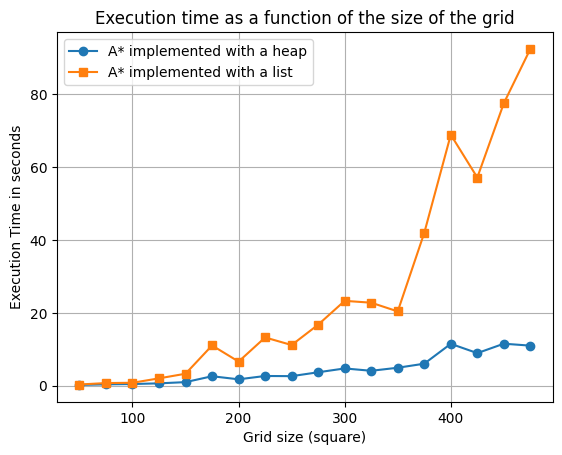

In [15]:

# Example data
list_astar_slow_init  = [0.3564584255218506, 0.759631872177124, 0.8661961555480957, 1.8854594230651855, 3.5382790565490723, 13.426698207855225, 7.388134956359863, 14.854499101638794, 12.845592498779297, 19.206965684890747, 24.14481782913208, 29.499228715896606, 24.332196950912476, 47.77089595794678, 78.73356556892395, 62.98393392562866, 80.5746603012085, 84.97348999977112]
  # Execution times for second algorithm

cities = np.arange(50,500, 25) # Number of cities
#y1 = list_astar_fast_grid  # Execution times for first algorithm
y2 = list_astar_slow_grid  # Execution times for second algorithm
#y3 = list_astar_slow_init  # Execution times for second algorithm

# Plotting
#plt.plot(cities, y1, marker='o', label='A* implemented with a heap')
plt.plot(cities, y2, marker='s', label='A* implemented with a list')
#plt.plot(cities, y3, marker='8', label='A* from package')

# Adding labels and title
plt.xlabel('Grid size (square)')
plt.ylabel('Execution Time in seconds')
plt.title('Execution time as a function of the size of the grid')

# Adding legend
plt.legend()

# Display plot
plt.grid(True)
plt.savefig('execution_time3_plot.png')

plt.show()


In [17]:
def show_env(env_renderer):
    env_renderer.render_env(show=False,  # whether to call matplotlib show() or equivalent after completion
                                show_agents=True,  # whether to include agents
                                show_inactive_agents=False,  # whether to show agents before they start
                                show_observations=True,  # whether to include observations
                                show_predictions=True,  # whether to include predictions
                                show_rowcols=True,  # label the rows and columns
                                frames=True,  # frame counter to show (intended since invocation)
                                episode=None,  # int episode number to show
                                step=None,  # int step number to show in image
                                selected_agent=None)  # indicate which agent is "selected" in the editor):
    plt.imshow(env_renderer.get_image())

In [18]:
import time

def benchmark(priority):
    set_priority(priority)
    mean = 0
    count = 0
    if priority:
        print("BENCHMARK: A* | Datastructure: Heap\n")
    else:
        print("BENCHMARK: A* | Datastructure: OrderedSet\n")
    
    print("|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  ")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    for size in range(50, 200, 50):
        height = size
        width = size
        for nr_cities in range(4, 20, 2):
            count+=1
            #for max_rail_in_cities in range(1,6, 2):
            #    for max_rail_btw_cities in range(1,6, 2):
            max_rail_in_cities = 4
            max_rail_btw_cities = 10
            env = create_env(height, width, nr_cities, max_rail_in_cities, max_rail_btw_cities, 
            seed)
            time1= time.time()
            env.reset()
            time2 = time.time()
            delta = time2-time1
            mean += delta
            print(f"|  Parameters   |        {height}      |        {width}      |       {nr_cities}       |        {max_rail_in_cities}         |         {max_rail_btw_cities}        |        {delta}            ")
            env_renderer =  RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1020,  # Adjust these parameters to fit your resolution
                          screen_width=1800)
            show_env(env_renderer)
                
    print(f"------------------------------------------------------------------------------------------------------| Mean: {mean/count}")


BENCHMARK: A* | Datastructure: Heap

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        50      |        50      |       4       |        4         |         10        |        0.5713798999786377            


/home/bob/EPFL/Bachelor_project/flatland-rl/flatland/utils/rendertools.py:397: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  warnings.warn(
/home/bob/EPFL/Bachelor_project/flatland-rl/flatland/utils/rendertools.py:418: UserWarning: Predictor did not provide any predicted cells to render.                 Predictors builder needs to populate: env.dev_pred_dict
  warnings.warn(


|  Parameters   |        50      |        50      |       6       |        4         |         10        |        0.6116800308227539            
|  Parameters   |        50      |        50      |       8       |        4         |         10        |        0.46214747428894043            
|  Parameters   |        50      |        50      |       10       |        4         |         10        |        0.6510806083679199            
|  Parameters   |        50      |        50      |       12       |        4         |         10        |        0.6188147068023682            
|  Parameters   |        50      |        50      |       14       |        4         |         10        |        0.61385178565979            
|  Parameters   |        50      |        50      |       16       |        4         |         10        |        0.556626558303833            
|  Parameters   |        50      |        50      |       18       |        4         |         10        |        0.54347825050

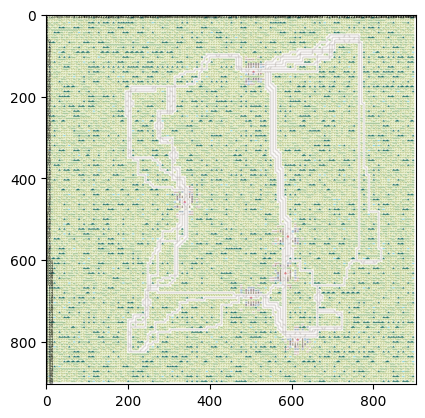

In [19]:
benchmark(True)

In [ ]:
benchmark(False)

BENCHMARK: A* | Datastructure: OrderedSet

|  Parameters   |     height     |      width     |  nr_cities    |max_rail_in_cities|max_rail_btw_cities|  Execution time  
-------------------------------------------------------------------------------------------------------------------------------------------
|  Parameters   |        50      |        50      |       4       |        4         |         10        |        0.9949345588684082            
|  Parameters   |        50      |        50      |       6       |        4         |         10        |        0.2129673957824707            
|  Parameters   |        50      |        50      |       8       |        4         |         10        |        0.2653517723083496            
|  Parameters   |        50      |        50      |       10       |        4         |         10        |        0.36807799339294434            
|  Parameters   |        50      |        50      |       12       |        4         |         10        |   

In [20]:
print("Initial positions",  [a.initial_position for a in env.agents])
print("Initial directions", [a.initial_direction for a in env.agents])
print("Earliest Departures", [a.earliest_departure for a in env.agents])
print("Targets", [a.target for a in env.agents])
print("Speed Counter values", [a.speed_counter.max_count for a in env.agents])

Initial positions [(60, 44), (93, 16)]
Initial directions [1, 1]
Earliest Departures [76, 15]
Targets [(94, 16), (61, 44)]
Speed Counter values [3, 3]


In [21]:
def show_agents(env):
    for agent in env.agents:
        print(agent.handle, "Position", agent.position, "State", agent.state, end='\t')
    print()

In [22]:
for _ in range(max(a.earliest_departure for a in env.agents)+ 1):
    env.step({0: RailEnvActions.DO_NOTHING, 1: RailEnvActions.DO_NOTHING})
show_agents(env)

0 Position None State TrainState.READY_TO_DEPART	1 Position None State TrainState.READY_TO_DEPART	


0 Position (60, 44) State TrainState.MOVING	1 Position (93, 16) State TrainState.MOVING	
0 Position (60, 44) State TrainState.MOVING	1 Position (93, 16) State TrainState.MOVING	
0 Position (60, 44) State TrainState.MOVING	1 Position (93, 16) State TrainState.MOVING	
0 Position (60, 44) State TrainState.MOVING	1 Position (93, 16) State TrainState.MOVING	
0 Position (60, 45) State TrainState.MOVING	1 Position (93, 17) State TrainState.MOVING	
0 Position (60, 45) State TrainState.MOVING	1 Position (93, 17) State TrainState.MOVING	
0 Position (60, 45) State TrainState.MOVING	1 Position (93, 17) State TrainState.MOVING	
0 Position (60, 45) State TrainState.MOVING	1 Position (93, 17) State TrainState.MOVING	
0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MOVING	


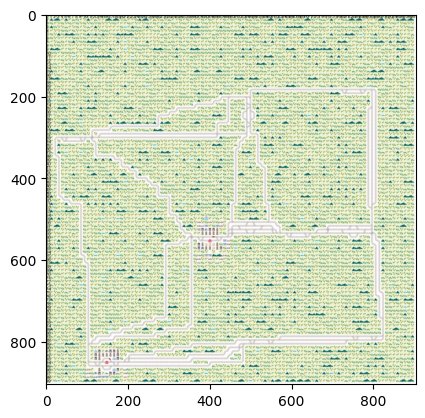

In [23]:
for _ in range(9):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.MOVE_FORWARD
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MOVING	


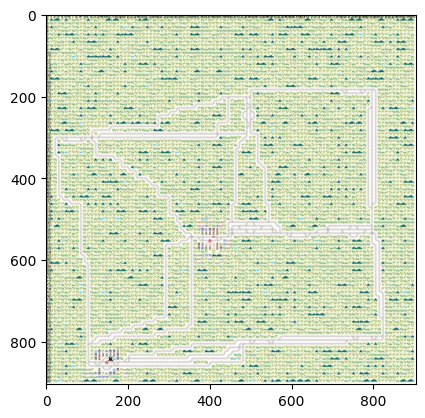

In [24]:
env.agents[1].malfunction_handler._set_malfunction_down_counter(100)
show_agents(env)
show_env(env_renderer)

0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MALFUNCTION	
0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MALFUNCTION	


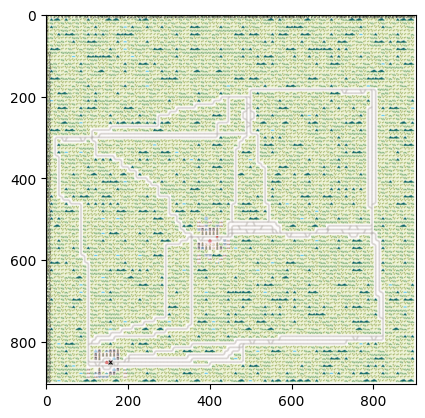

In [25]:
for _ in range(2):
    action_dict = {}
    action_dict[0] = RailEnvActions.MOVE_FORWARD
    action_dict[1] = RailEnvActions.STOP_MOVING
    env.step(action_dict);
    show_agents(env)
show_env(env_renderer)

In [26]:
show_agents(env)

0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MALFUNCTION	


0 Position (60, 46) State TrainState.MOVING	1 Position (94, 17) State TrainState.MALFUNCTION	


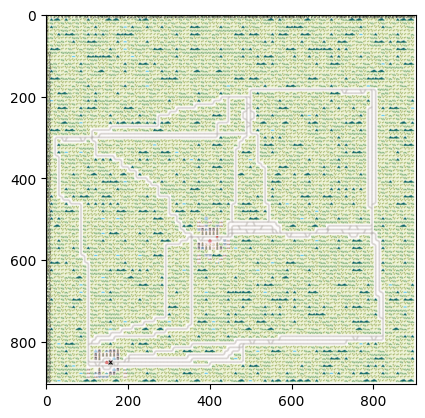

In [27]:
action_dict = {}
action_dict[0] = RailEnvActions.MOVE_FORWARD
action_dict[1] = RailEnvActions.STOP_MOVING
env.step(action_dict);
show_agents(env)
show_env(env_renderer)

In [28]:
import numpy as np
import os

from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters, ParamMalfunctionGen

from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
#from flatland.envs.sparse_rail_gen import SparseRailGen
from flatland.envs.schedule_generators import sparse_schedule_generator


def get_small_two_agent_env():
    """Generates a simple 2 city 2 train env returns it after reset"""
    width = 30  # With of map
    height = 15  # Height of map
    nr_trains = 2  # Number of trains that have an assigned task in the env
    cities_in_map = 2 # Number of cities where agents can start or end
    seed = 42  # Random seed
    grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
    max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
    max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

    rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                        seed=seed,
                                        grid_mode=grid_distribution_of_cities,
                                        max_rails_between_cities=max_rails_between_cities,
                                        max_rail_pairs_in_city=max_rail_in_cities//2,
                                        )
    speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

    schedule_generator = sparse_schedule_generator(speed_ration_map)


    stochastic_data = MalfunctionParameters(malfunction_rate=1/10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )

    observation_builder = GlobalObsForRailEnv()

    env = RailEnv(width=width,
                height=height,
                rail_generator=rail_generator,
                schedule_generator=schedule_generator,
                number_of_agents=nr_trains,
                obs_builder_object=observation_builder,
                #malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                malfunction_generator=ParamMalfunctionGen(stochastic_data),
                remove_agents_at_target=True,
                random_seed=seed)

    env.reset()

    return env

ImportError:  Schedule Generators is now renamed to line_generators, any reference to schedule should be replaced with line

In [ ]:
env = get_small_two_agent_env()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=600,  # Adjust these parameters to fit your resolution
                          screen_width=800)

i_agent = 1
ed = env.agents[i_agent].earliest_departure
for _ in range(ed):
    env.step({i_agent: RailEnvActions.DO_NOTHING})

show_agents(env)
show_env(env_renderer)

In [ ]:
for _ in range(50):
    env.step({i_agent: RailEnvActions.MOVE_FORWARD})

show_agents(env)
show_env(env_renderer)

In [ ]:
show_agents(env)
show_env(env_renderer)
